In [1]:
'''BASIC'''
import numpy as np
import pandas as pd
import random as rand
import datetime
import math
import os
import itertools as itr
import warnings
warnings.simplefilter('ignore')
'''PLOT'''
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
font = {'size':16}
'''STATS'''
import scipy.stats as scs
import statsmodels.api as sm
'''SCIKIT LEARN'''
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, r2_score, mean_squared_error, classification_report, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from sklearn.metrics import roc_curve, auc

from src.plot_confusion_matrix import plot_confusion_matrix

from imblearn.over_sampling import SMOTE

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

'''RETURN'''
os.system("say 'loading complete' &");

In [2]:
def churnpipe(file, disp=False, split=True, impute=True, test_size=0.33, random_state=777):
    # read
    X = pd.read_csv('data/'+file)
    # create labels based on usage in last 30 days
    y = pd.to_datetime(X.pop('last_trip_date')) < pd.to_datetime('2014-06-01')
    # dummies for null ratings or impute
    if impute == True:
        X['avg_rating_by_driver'].fillna(0, inplace=True)
        X['avg_rating_of_driver'].fillna(0, inplace=True)
    else:
        X['rating_by_driver_missing'] = X['avg_rating_by_driver'].isnull()
        X['rating_of_driver_missing'] = X['avg_rating_of_driver'].isnull()
        X.drop(['avg_rating_by_driver', 'avg_rating_of_driver'], axis=1, inplace=True)
    # dummies for categorical
    X = X.join(pd.get_dummies(X['phone'], prefix='phone', prefix_sep='_', dummy_na=True))
    X = X.join(pd.get_dummies(X['city'], prefix='city', prefix_sep='_', dummy_na=True))
    # remove useless predictors
    X.drop(['phone', 'city', 'signup_date'], axis=1, inplace=True)
    # printout
    if disp == True:
        print(X.info())
        print(y.value_counts(normalize=True))
    # output
    if split == True:
        return train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X, y


In [3]:
def evaluate_model(clf, X, y):
    predicted = clf.predict(X)
    accuracy = accuracy_score(y, predicted)
    precision = precision_score(y, predicted)
    recall = recall_score(y, predicted)
    print(f"Accuracy Score: {accuracy}")
    print(f"Precision Score: {precision}")
    print(f"Recall Score: {recall}")


In [4]:
# def gdbr(X_train,y_train,X_test,y_test):
#     learning_rates = [0.02, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
#     # best_score = 0
#     # best_learning_rate = 0.05

#     for learning_rate in learning_rates:
#         gb = GradientBoostingClassifier(
#             n_estimators=300, learning_rate=learning_rate, max_depth=3, random_state=0
#         ).fit(X_train, y_train)
#         print("Learning rate: ", learning_rate)

#         current_accuracy = evaluate_model(
#             clf=gb,
#             X=X_test,
#             y=y_test,
#             title=gb.__class__.__name__,
#             img_name= GradientBoostingClassifier,
#         )
#         print()

In [5]:
def plot_roc(clf,X_train,y_train,X_test,y_test):

    clf.fit(X_train,y_train)
    y_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC')
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show();

In [6]:
def mod_opt(X_train,y_train):
    gdbr_grid = {
    #                       'max_features': ['sqrt', 'log2', None],
                          'learning_rate': [0.01,0.05,0.1],
                          'min_samples_leaf': [1],

                          'n_estimators': [100],
                          'random_state': [1]}

    gdbr_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                                 gdbr_grid,

                                 cv = 3,
                                 verbose=True,
                                 scoring='precision')
    gdbr_gridsearch.fit(X_train, y_train)

    print("best parameters:", gdbr_gridsearch.best_params_)

    return gdbr_gridsearch.best_estimator_




In [7]:

def feat_importance(best_gdbr_model):

    
    model_opt = best_gdbr_model.fit(X_train,y_train)
    feature_importances = 100*model_opt.feature_importances_ / np.sum(model_opt.feature_importances_)
    feature_importances, feature_names, feature_idxs = \
        zip(*sorted(zip(feature_importances, names, range(len(names)))))

    width = 0.8

    idx = np.arange(len(names))
    plt.barh(idx, feature_importances, align='center')
    plt.yticks(idx, feature_names)

    plt.title("Feature Importance in GradientBoosting Classifier")
    plt.xlabel('Relative Importance of Feature', fontsize=14)
    plt.ylabel('Feature Name', fontsize=14);

In [8]:
def smote_split():
#     print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
#     print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

    sm = SMOTE(random_state=2)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
    return X_train_res, y_train_res 

    print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
    print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

    print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
    print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))
    

Before OverSampling, counts of label '1': 16689
Before OverSampling, counts of label '0': 10111 

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   13.3s finished


best parameters: {'learning_rate': 0.1, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 1}

Accuracy Score: 0.7896969696969697
Precision Score: 0.8128482092097783
Recall Score: 0.8635100857591497



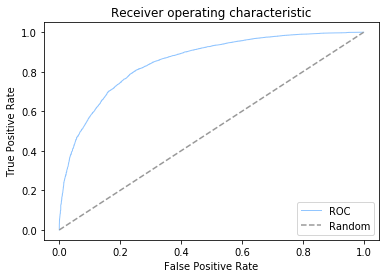


Normalized confusion matrix
[[0.81284821 0.18715179]
 [0.25652667 0.74347333]]


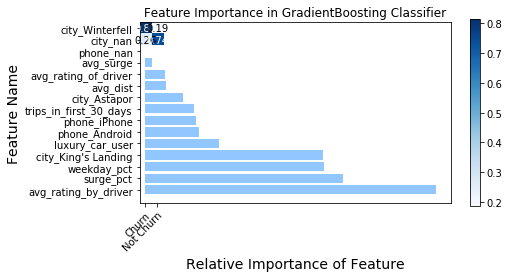

In [9]:
# Scenario 1: impute missing ratings, no oversampling

X_train, X_test, y_train, y_test = churnpipe('churn_train.csv')
names = list(X_train.columns)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

best_gdbr_model_1 = mod_opt(X_train,y_train)
print()
evaluate_model(best_gdbr_model_1, X_test, y_test)
print()
plot_roc(best_gdbr_model_1 ,X_train,y_train,X_test,y_test)
print()
y_pred = best_gdbr_model_1.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=['Churn','Not Churn'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)
print()
feat_importance(best_gdbr_model_1)

Before OverSampling, counts of label '1': 16689
Before OverSampling, counts of label '0': 10111 

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   18.9s finished


best parameters: {'learning_rate': 0.1, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 1}

Accuracy Score: 0.7843181818181818
Precision Score: 0.8265993265993266
Recall Score: 0.8302935137093852



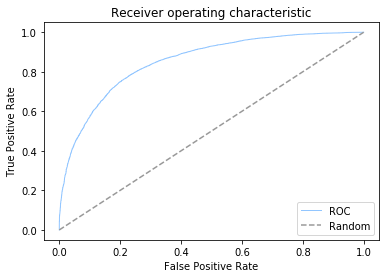


Normalized confusion matrix
[[0.82659933 0.17340067]
 [0.28767404 0.71232596]]


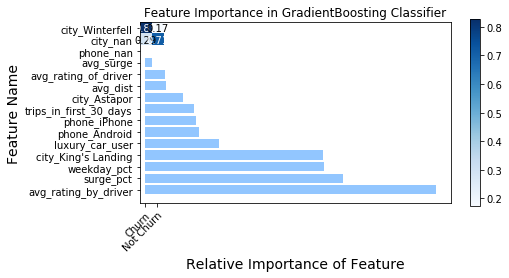

In [10]:
# Scenario 2: impute missing ratings, implement oversampling

X_train, X_test, y_train, y_test = churnpipe('churn_train.csv')
names = list(X_train.columns)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

# Implement oversampling

X_train_res, y_train_res = smote_split()

best_gdbr_model_2 = mod_opt(X_train_res,y_train_res)
print()
evaluate_model(best_gdbr_model_2, X_test, y_test)
print()
plot_roc(best_gdbr_model_2 ,X_train_res,y_train_res,X_test,y_test)
print()
y_pred = best_gdbr_model_2.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=['Churn','Not Churn'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

print()
feat_importance(best_gdbr_model_2)

Before OverSampling, counts of label '1': 16689
Before OverSampling, counts of label '0': 10111 

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   12.7s finished


best parameters: {'learning_rate': 0.1, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 1}

Accuracy Score: 0.7812878787878788
Precision Score: 0.8033986045464776
Recall Score: 0.8623022104118855



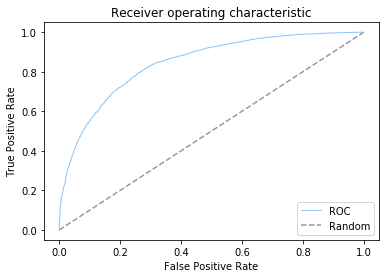


Normalized confusion matrix
[[0.8033986  0.1966014 ]
 [0.26425591 0.73574409]]


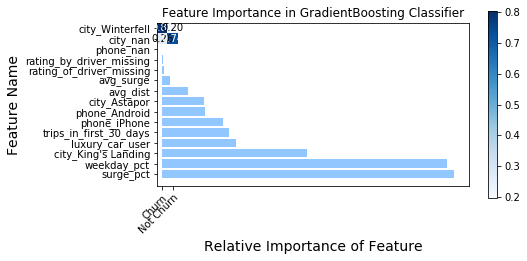

In [11]:
# Scenario 3: not imputing missing ratings, use ratings dummies,no oversampling

X_train, X_test, y_train, y_test = churnpipe('churn_train.csv',impute=False)

names = list(X_train.columns)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

best_gdbr_model_3 = mod_opt(X_train,y_train)
print()
evaluate_model(best_gdbr_model_3, X_test, y_test)
print()
plot_roc(best_gdbr_model_3 ,X_train,y_train,X_test,y_test)
print()
y_pred = best_gdbr_model_3.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=['Churn','Not Churn'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

print()
feat_importance(best_gdbr_model_3)

Before OverSampling, counts of label '1': 16689
Before OverSampling, counts of label '0': 10111 

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   17.4s finished


best parameters: {'learning_rate': 0.1, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 1}

Accuracy Score: 0.7758333333333334
Precision Score: 0.8281519861830743
Recall Score: 0.8108467206184322



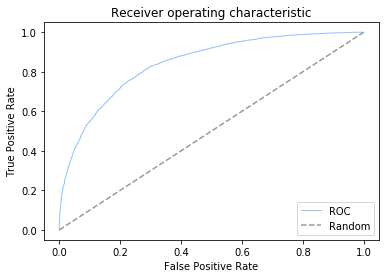


Normalized confusion matrix
[[0.82815199 0.17184801]
 [0.30742049 0.69257951]]


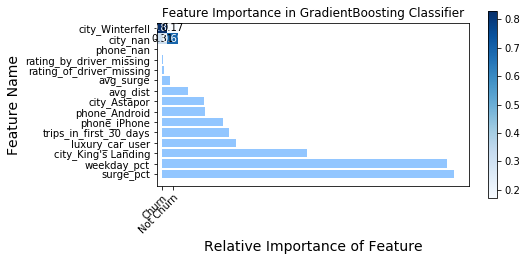

In [12]:
# Scenario 4: not imputing missing ratings, use ratings dummies,implement oversampling

X_train, X_test, y_train, y_test = churnpipe('churn_train.csv',impute=False)

names = list(X_train.columns)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

# Implement oversampling

X_train_res, y_train_res = smote_split()

best_gdbr_model_4 = mod_opt(X_train_res,y_train_res)
print()
evaluate_model(best_gdbr_model_4, X_test, y_test)
print()
plot_roc(best_gdbr_model_4 ,X_train_res,y_train_res,X_test,y_test)
print()
y_pred = best_gdbr_model_4.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=['Churn','Not Churn'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

print()
feat_importance(best_gdbr_model_4)

Apple the model to the churn_text data

In [16]:
X,y = churnpipe('churn_test.csv', split=False, test_size=0.33, random_state=777)
evaluate_model(best_gdbr_model_1, X, y)
print()

X,y = churnpipe('churn_test.csv', split=False, test_size=0.33, random_state=777)
evaluate_model(best_gdbr_model_2, X, y)


Accuracy Score: 0.7156
Precision Score: 0.7409569923098832
Recall Score: 0.8354206807964033

Accuracy Score: 0.7811
Precision Score: 0.8025468164794007
Recall Score: 0.8601477199743096


In [17]:
X,y = churnpipe('churn_test.csv', split=False, impute = False,test_size=0.33, random_state=777)
evaluate_model(best_gdbr_model_3, X, y)
print()

X,y = churnpipe('churn_test.csv', split=False, impute = False,test_size=0.33, random_state=777)
evaluate_model(best_gdbr_model_4, X, y)

Accuracy Score: 0.7725
Precision Score: 0.7947800149142431
Recall Score: 0.8556518946692357

Accuracy Score: 0.7725
Precision Score: 0.7947800149142431
Recall Score: 0.8556518946692357


In [ ]:
y_prob = best_gdbr_model_1.predict_proba(X)
fpr, tpr, thresholds = roc_curve(y, y_prob[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC')
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show();

Normalized confusion matrix
[[0.80254682 0.19745318]
 [0.26195489 0.73804511]]


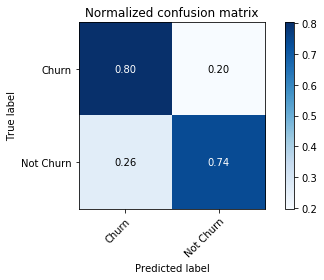

In [14]:
y_pred = best_gdbr_model_1.predict(X)
plot_confusion_matrix(y, y_pred, classes=['Churn','Not Churn'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)


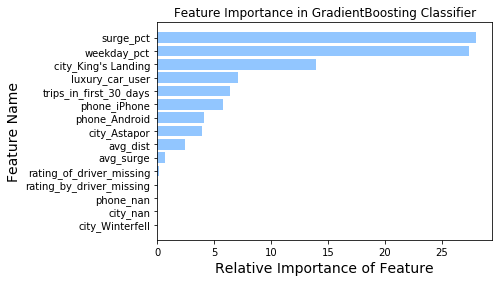

In [15]:
feat_importance(best_gdbr_model_1)